# Laboratory 4: Reinforcement learning
    
In the end of the lab, you should export the notebook to a Python script (``File >> Download as >> Python (.py)``). Make sure that the resulting script includes all code written in the tasks marked as \"**Activity n. N**\", together with any replies to specific questions posed. Your file should be named `padi-labKK-groupXXX.py`, where `KK` corresponds to the lab number and the `XXX` corresponds to your group number. Similarly, your homework should consist of a single pdf file named `padi-hwKK-groupXXX.pdf`. You should create a zip file with the lab and homework files and submit it in Fenix **at most 30 minutes after your lab is over**.
    
Make sure to strictly respect the specifications in each activity, in terms of the intended inputs, outputs and naming conventions.
    


### Golf environment

We consider a very simple golf simulator with one continuous dimension. The goal is to reach the hole in the minimum amount of plays. We let $x \in [0,450]$ be the continuous random variable encoding the position of the ball in the golf course. We consider 4 golf courses, which differ in the position of the hole and wind intensity. The maximum length across all golf courses is of 450 meters.

There are 6 different actions corresponding to 6 golf clubs:
*   Long range (action 0 - more precise, action 1 - less precise)
*   Medium range (action 2 - more precise, action 3 - less precise)
*   Short range (action 4 - more precise, action 5 - less precise)

The function `golf_env_step(env, x, a)` provides a simulator for this game, where `env` is a number (0-3) corresponding to a given golf course, `x` is the current location of the ball, and `a` the action. The function returns the new location of the ball and the cost (0 if it entered the hole, 1 otherwise). When the ball enters the hole, the cost is 0 and the environment resets to its initial configuration where the ball is in position 0 again.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

def golf_env_step(env, x, a):

    if env == 0:
        xgoal = 200
        wind = -10
    elif env == 1:
        xgoal = 200
        wind = 10
    elif env == 2:
        xgoal = 400
        wind = -20
    elif env == 3:
        xgoal = 400
        wind = +10

    if a == 0:
        x = x + np.sign(xgoal-x) * (np.random.normal() * 10 + 100) + wind
    elif a == 1:
        x = x + np.sign(xgoal-x) * (np.random.normal() * 30 + 150) + wind
    elif a == 2:
        x = x + np.sign(xgoal-x) * (np.random.normal() * 5 + 50) + wind/2
    elif a == 3:
        x = x + np.sign(xgoal-x) * (np.random.normal() * 15 + 75) + wind/2
    elif a == 4:
        x = x + np.sign(xgoal-x) * (np.random.normal() * 1) + min((xgoal-x),10)
    elif a == 5:
        x = x + np.sign(xgoal-x) * (np.random.normal() * 4 + 2 * min((xgoal-x),20)) + wind/4

    x = np.double(x)
    if x < 0:
        x = 0
    elif x > 450:
        x = 450

    if np.abs(x-xgoal) < 1:
        c = 0
        x = 0
    else:
        c = 1

    return x, c

In [2]:
ENV = 2 # The golf course to consider.

## Activity 1 ##
As the state is continuous, we cannot apply directly Q-Learning. One common approach is to discretize the continuous state value into a discrete number. Make a simple function that converts the continuous state $x \in [0,450]$ into a discrete number corresponding to a state index.

Implement the function `state2rep(x)` below, which receives the continuous state $x$ and returns the index corresponding to a discrete state. Let's assume we choose a maximum of 46 discrete states. Take a look into the prints below to understand how the discretization procedure is supposed to work.

In [3]:
def state2rep(x):
    return int (x // 10)

In [4]:
print("x = 0.0:", state2rep(0.0))
print("x = 5.0:", state2rep(5.0))
print("x = 9.9:", state2rep(9.9))
print("x = 10.0:", state2rep(10.0))
print("x = 15.0:", state2rep(15.0))
print("x = 19.9:", state2rep(19.9))
print("x = 200.0:", state2rep(200.0))
print("x = 205.0:", state2rep(205.0))
print("x = 209.9:", state2rep(209.9))
print("x = 440.0:", state2rep(440.0))
print("x = 449.9:", state2rep(449.9))
print("x = 450.0:", state2rep(450.0))

x = 0.0: 0
x = 5.0: 0
x = 9.9: 0
x = 10.0: 1
x = 15.0: 1
x = 19.9: 1
x = 200.0: 20
x = 205.0: 20
x = 209.9: 20
x = 440.0: 44
x = 449.9: 44
x = 450.0: 45


The following code



```
print("x = 0.0:", state2rep(0.0))
print("x = 5.0:", state2rep(5.0))
print("x = 9.9:", state2rep(9.9))
print("x = 10.0:", state2rep(10.0))
print("x = 15.0:", state2rep(15.0))
print("x = 19.9:", state2rep(19.9))
print("x = 200.0:", state2rep(200.0))
print("x = 205.0:", state2rep(205.0))
print("x = 209.9:", state2rep(209.9))
print("x = 440.0:", state2rep(440.0))
print("x = 449.9:", state2rep(449.9))
print("x = 450.0:", state2rep(450.0))
```


should give the result


```
x = 0.0: 0
x = 5.0: 0
x = 9.9: 0
x = 10.0: 1
x = 15.0: 1
x = 19.9: 1
x = 200.0: 20
x = 205.0: 20
x = 209.9: 20
x = 440.0: 44
x = 449.9: 44
x = 450.0: 45
```





## Activity 2 ##

Now that we are in a discrete environment, we can apply directly the Q-Learning algorithm. Implement function `Qlearning` below, which lets the agent interact with the environment for `Niter` iterations while following an $\epsilon$-greedy policy and performing a Q-learning update at each step. The initial state corresponds to $x =0$.

```
Qlearning(env, Ns, Na, egreedy = 0.1, gamma = 0.9, lr = 0.1, Niter = 100)
```
* `env`: the index of the golf course (0-3)
* `Ns`: the number of discrete states choosen
* `Na`: the number of actions
* `egreedy`: factor for exploration where random actions are choosen `egreedy`*100 percent of the time
* `gamma`: the discount factor
* `lr`: the learning rate
* `Niter`: the number of iterations to learn


In [5]:
def Qlearning(env, Ns, Na, egreedy=0.1, gamma=0.9, lr=0.1, Niter=100):
    # Initialize Q-table with zeros
    Q = np.zeros((Ns, Na))

    # Niter iterations
    for _ in range(Niter):
        # Initial state (x = 0)
        state = 0

        while True:
            # E-greedy policy: choose action
            if np.random.rand() < egreedy:  # Exploration
                action = np.random.randint(Na)
            else:  # Exploitation
                action = np.argmin(Q[state])

            # Take action, get new state and cost
            new_state, cost = golf_env_step(env, state * 10, action)

            # Convert new state to discrete index (state2rep function)
            new_state_idx = state2rep(new_state)

            # Q-learning update
            Q[state, action] += lr * (cost + gamma * np.min(Q[new_state_idx]) - Q[state, action])

            # Update the state
            state = new_state_idx

            # If the ball has reached the hole (cost = 0), break the loop
            if cost == 0:
                break

    return Q

Run the following code:

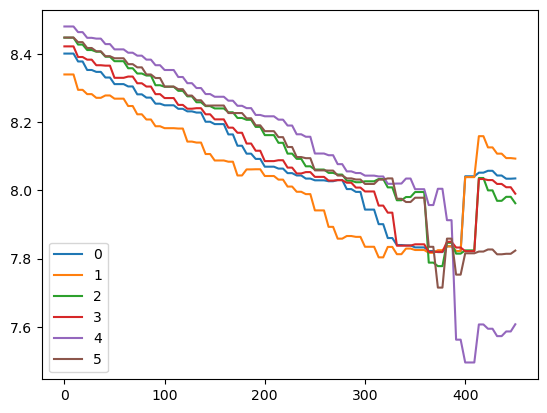

In [6]:
Q = Qlearning(env = ENV, Ns = 46, Na = 6, egreedy = 0.1, gamma = 0.9, lr = 0.1, Niter = 1_000_000)

xs = np.linspace(0.0, 450.0, 100)
xs_discrete = [state2rep(x) for x in xs]
plt.figure()
plt.plot(xs, Q[xs_discrete,:])
plt.legend(['0','1','2','3','4','5'])

**Question 1:** What is the optimal action at the discrete state associated with $x=0$, and the optimal action at the discrete state associated with $x=420$?

**Answer 1:** By observing the graph (Q-learning), it can be seen that the optimal actions for the two states are:
- $x=0$: action 1
- $x=420$: action 4.

## Learning with function approximation. ##

When the number of states is very large, or the problem is continuous, the previous approach does not scale. In those cases, we need to resort to function approximation to approximate the Q-values. Consider the following parametrization of the Q-function

$$Q_\theta(x,a) = \theta_a^\top f(x)$$

where: (i) $\theta_a \in \mathbb{R}^2$ are the learnable parameters for each of the actions; and (ii) the features vector is given by

$$f(x) = \bigg[\frac{x}{450},1\bigg]^\top.$$

We follow a fitted Q-iteration approach where we first collect data by interacting with the environment, then use the collected data to build targets for the regression problem, and finally solve a regression problem to find the new set of parameters $\theta_a^\text{new}$ for each of the actions.

In the following activities we will implement each step separately.

## Activity 3 ##
Implement function `x_to_features`, which receives a vector $x$ of size $(N,)$ containing a set of $N$ positions $x$ and returns a matrix with size $(2 \times N)$ where each column contains the feature associated with each of the $x$ points.

`x_to_features(x)`

* x: np.array containing a set of $x$ points


In [7]:
def x_to_features(x):
    return np.vstack([x / 450, np.ones_like(x)])

In [8]:
x_test_1 = np.array([311.9])
f_test_1 = x_to_features(x_test_1)
print(f_test_1)
print(f_test_1.shape)

x_test_2 = np.array([0.0, 86.6, 148.1, 231.5, 311.9])
f_test_2 = x_to_features(x_test_2)
print(f_test_2)
print(f_test_2.shape)

[[0.69311111]
 [1.        ]]
(2, 1)
[[0.         0.19244444 0.32911111 0.51444444 0.69311111]
 [1.         1.         1.         1.         1.        ]]
(2, 5)


The following code



```
x_test_1 = np.array([311.9])
f_test_1 = x_to_features(x_test_1)
print(f_test_1)
print(f_test_1.shape)

x_test_2 = np.array([0.0, 86.6, 148.1, 231.5, 311.9])
f_test_2 = x_to_features(x_test_2)
print(f_test_2)
print(f_test_2.shape)
```


should give the result


```
[[0.69311111]
 [1.        ]]
(2, 1)
[[0.         0.19244444 0.32911111 0.51444444 0.69311111]
 [1.         1.         1.         1.         1.        ]]
(2, 5)
```





## Activity 4 ##
Implement function `genTraj`, which receives a matrix $\theta$ of size $(2 \times Na)$, where $Na$ is the number of actions, containing a set of parameters. The function should sample a sequence of $(x_t, a_t, c_t, x_{t+1})$ transition tuples by interacting with the MDP. Action selection is performed according to an $\epsilon$-greedy policy with respect to the Q-function induced by the parameters $\theta$. The function should return an array with size $(Niter \times 4)$ where each line corresponds to a single transition $(x_t, a_t, c_t, x_{t+1})$. Assume the initial state of the trajectory is $x=0$.

`genTraj(env, theta, Niter = 20, egreedy = 0.1)`

* `env`: the index of the golf course (0-3)
* theta: coefficients of the approximation of the Q function
* Niter: the number of transitions to sample
* egreedy - factor for exploration where random actions are choosen `egreedy`*100 percent of the time


In [9]:
def genTraj(env, theta, Niter=20, egreedy=0.1):
    # Initial state
    x = 0
    transitions = list()

    # Iterate for Niter steps
    for _ in range(Niter):
        # Calculate Q-values for each action
        features = x_to_features(x)
        Q_values = np.dot(features.T, theta).flatten()  # Q-values for all actions

        # E-greedy policy: Choose the best action or explore randomly
        if np.random.rand() < egreedy:
            a = np.random.choice(6)  # Exploration
        else:
            a = np.argmin(Q_values)  # Exploitation

        # Get the next state, reward, and terminal condition from the environment
        x_next, c = golf_env_step(env, x, a)

        # Store the transition (x_t, a_t, c_t, x_{t+1})
        transitions.append([x, a, c, x_next])

        # Update the state for the next iteration
        x = x_next

    # Return transitions as a numpy array of shape (Niter, 4)
    return np.array(transitions)

In [10]:
np.random.seed(1640)
Na = 6
theta = np.ones([2, Na])
T = genTraj(env = ENV, theta = theta, Niter = 8, egreedy = 0.1)
print(T)
print(T.shape)

[[  0.           0.           1.          86.61210274]
 [ 86.61210274   0.           1.         148.15779329]
 [148.15779329   4.           1.         158.82906467]
 [158.82906467   0.           1.         233.83829403]
 [233.83829403   0.           1.         310.67242707]
 [310.67242707   0.           1.         381.19868819]
 [381.19868819   0.           1.         450.        ]
 [450.           0.           1.         331.59316938]]
(8, 4)


The following code



```
np.random.seed(1640)
Na = 6
theta = np.ones([2, Na])
T = genTraj(env = ENV, theta = theta, Niter = 8, egreedy = 0.1)
print(T)
print(T.shape)
```


should give the result


```
[[  0.           0.           1.          86.61210274]
 [ 86.61210274   0.           1.         148.15779329]
 [148.15779329   4.           1.         158.82906467]
 [158.82906467   0.           1.         233.83829403]
 [233.83829403   0.           1.         310.67242707]
 [310.67242707   0.           1.         381.19868819]
 [381.19868819   0.           1.         450.        ]
 [450.           0.           1.         331.59316938]]
(8, 4)
```





## Activity 5 ##
We now implement function `updateCoef`, which performs a step of the fitted-Q-iteration algorithm. The function receives a trajectory `T` and set of parameters $\theta$ and returns the updated parameters $\theta^\text{new}$, which correspond to the new parameters after a single learning step of the fitted-Q-iteration algorithm. The function should perform the updates separately for each action $a$. First, the function should select all transitions $(x_t,a_t,c_t, x_{t+1})$ associated with action $a$, i.e, select all transitions $(x_t,a_t,c_t, x_{t+1})$ such that $a_t=a$. Then, we need to calculate the regression targets $y_a$ for each of the transition tuples associated with action $a$ as $y_{a,t} = c_t + \gamma \min_a \{ \theta_a^\top f(x_{t+1}) \}$. Finally, for the transition tuples associated with action $a$, we compute the new set of parameters $\theta^\text{new}_a$ by solving the regression problem with inputs $f(x_t)$ and target values $y_a$. The new parameters $\theta_a^\text{new}$ can be calculated using the following least-squares solution: $\theta_a^\text{new} = (f_a^\top f_a)^{-1} f_a^\top y_a$, where $f_a \in \mathbb{R}^{n_a, 2}$ is the feature matrix of the inputs $x_t$ associated with action $a$ and $y_a \in \mathbb{R}^{n_a}$ is the vector of targets associated with action $a$ ($n_a$ is the number of transitions in `T` associated with action $a$). We then repeat for each of the actions.

```
updateCoef(T, theta, gamma = 0.9, Na = 6)
```

* T: a trajectory of transitions
* theta: the set of learnable parameters
* gamma: discount factor
* Na: the number of actions




In [11]:
def updateCoef(T, theta, gamma=0.9, Na=6):
    # Initialize new theta with zeros
    theta_new = theta.copy()

    # Iterate over each action
    for a in range(Na):
        # Select transitions where action a was taken
        transitions_a = T[T[:, 1] == a]             # Shape (n_a, 4)

        # If there are no transitions for this action, skip
        if len(transitions_a) == 0:
            continue

        # Extract x_t, c_t, x_{t+1} for these transitions
        x_t = transitions_a[:, 0]                  # Shape (n_a,)
        c_t = transitions_a[:, 2]                  # Shape (n_a,)
        x_t_plus_1 = transitions_a[:, 3]           # Shape (n_a,)

        # Compute features for x_t (for regression inputs)
        f_a = x_to_features(x_t).T                 # Shape (nt, 2)

        # Compute targets y_{a,t} = c_t + gamma * min_a' Q(x_{t+1}, a')
        # Compute Q-values for next states x_{t+1}
        features_next = x_to_features(x_t_plus_1)  # Shape (2, n_a)
        Q_next = np.dot(theta.T, features_next)    # Shape (Na, n_a)
        min_Q_next = np.min(Q_next, axis=0)        # Shape (n_a,)

        y_a = c_t + gamma * min_Q_next             # Shape (n_a,)

        # Least squares: theta_a = (F.T @ F)^(-1) @ F.T @ y_a
        A = np.dot(f_a.T, f_a)                     # Shape (2, 2)
        b = np.dot(f_a.T, y_a)                     # shape (2,)
        theta_a_new = np.linalg.pinv(A).dot(b)     # Shape (2,)

        # Update the parameters for action a
        theta_new[:, a] = theta_a_new              # Shape (2, Na)

    return theta_new

In [12]:
np.random.seed(1640)
theta = np.ones([2,Na]) / Na
T = genTraj(env = ENV, theta = theta, Niter = 8, egreedy = 0.1)
updated_theta = updateCoef(T, theta, Na)
print(updated_theta)
print(updated_theta.shape)

[[0.71682535 0.16666667 0.16666667 0.16666667 0.698923   0.16666667]
 [2.24761608 0.16666667 0.16666667 0.16666667 2.12284039 0.16666667]]
(2, 6)


The following code



```
np.random.seed(1640)
theta = np.ones([2,Na]) / Na
T = genTraj(env = ENV, theta = theta, Niter = 8, egreedy = 0.1)
updated_theta = updateCoef(T, theta, Na)
print(updated_theta)
print(updated_theta.shape)
```


should give the result


```
[[0.71682535 0.         0.         0.         0.698923   0.        ]
 [2.24761608 0.         0.         0.         2.12284039 0.        ]]
(2, 6)
```





You can now use the following code below to run multiple steps of the fitted-Q-iteration algorithm.

(2, 100)


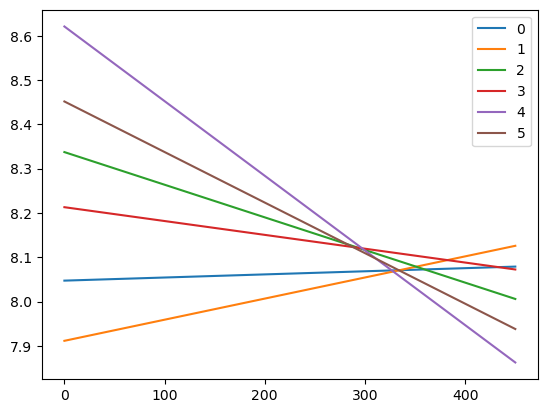

In [13]:
Na = 6
np.random.seed(1640)
theta = np.ones([2,Na]) / Na

for ii in np.arange(0, 500):
    T = genTraj(env = ENV, theta = theta, Niter = 1000, egreedy = 0.1)
    theta = updateCoef(T, theta, gamma = 0.9, Na = 6)
    # print(np.sum(T[:,2]))

xs = np.linspace(0.0, 450.0, 100)
ftoplot = np.concatenate([x_to_features(np.array([x])) for x in xs], axis=1)
print(ftoplot.shape)
plt.plot(xs, ftoplot.T@theta)
plt.legend(['0','1','2','3','4','5'])

**Question 2:** According to the fitted-Q-iteration algorithm, what is the optimal action at $x=0$, and the optimal action at $x=420$?

**Answer 2:** By observing the graph (fitted-Q-iteration), it can be seen that the optimal actions for the two states are:
- $x=0$: action 1
- $x=420$: action 4.

**Question 3:** Can you think of any limitation(s) when applying the discretized Q-learning algorithm to solve the golf problem we considered in this lab? Can you think of any limitation(s) when applying the fitted-Q-learning algorithm with linear function approximation (fixed features) to solve the golf problem we considered in this lab?

**Answer 3:**
#### Limitations when applying the discretized Q-learning:
- The state space (distance from the hole) is continuous, and discretizing it into bins can lead to a large number of states if high precision is needed. Too few bins may lose important information (e.g., small differences in distance), while too many bins increase computational cost.
- Discretization treats nearby states as entirely different, preventing the algorithm from generalizing across similar states. For example, if the ball is at 143m vs. 144m, discretization might treat them as different states even though the optimal action is likely similar.
- Wind is a continuous disturbance, and discretization may fail to capture its impact accurately, leading to suboptimal policies.
- Since discretized Q-learning explores state-action pairs independently, it may waste samples on irrelevant states (e.g., overshooting the hole repeatedly).
#### Limitations of Fitted Q-Learning with Linear Function Approximation:
- Linear approximation assumes that the Q-function is a linear combination of features, which may be too simplistic for the golf problem. If the true Q-function is highly nonlinear (e.g., due to wind effects), linear approximation may fail to capture optimal policies.
- Performance heavily relies on hand-designed features (x/450 and a bias term in this case). Poorly chosen features (e.g., not accounting for wind properly) can lead to bad approximations.
- If the number of transitions is small, the least-squares regression in fitted Q-learning may overfit, leading to poor generalization.
- Fitted Q-learning uses its own estimates for target values `y = c + γ min Q(x', a')`, which can propagate errors if initial estimates are poor. This can lead to divergence or unstable learning, especially with linear approximation.
- If the wind changes unpredictably (e.g., switching direction), linear approximation may struggle to adapt because it assumes fixed features.